In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
#import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.geodesic import Geodesic
land_color = [85/255, 92/255, 105/255]
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=land_color)
plt.rcParams['axes.grid'] = True
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import numpy as np
import xarray as xr
import pandas as pd
import gsw
import os,glob
import datetime
etopo = xr.open_dataset('/home1/datawork/kbalem/ETOPO1_Bed_g_gmt4.nc')
gebco = xr.open_dataset('/home1/datawork/kbalem/GEBCO_2019.nc')

## DEV/TEST  

---

In [202]:
dft=xr.open_dataset('/home/ref-argo/gdac/dac/coriolis/6902974/6902974_Rtraj.nc')

In [207]:
i=98
dft0 = dft[['CYCLE_NUMBER','JULD','PRES','LATITUDE','LONGITUDE','MEASUREMENT_CODE']].where(dft['CYCLE_NUMBER']==i,drop=True).sortby('JULD')
ascent_end = dft0.where(dft0['MEASUREMENT_CODE']==590,drop=True).groupby('CYCLE_NUMBER').last()  
tr_start = dft0.where(dft0['MEASUREMENT_CODE']==700,drop=True)
tr_end = dft0.where(dft0['MEASUREMENT_CODE']==800,drop=True)
first_fix = dft0.where(dft0['MEASUREMENT_CODE']==703,drop=True).groupby('CYCLE_NUMBER').first()      

descent_start = dft0.where(dft0['MEASUREMENT_CODE']==704,drop=True)
#dft1 = dft[['CYCLE_NUMBER','JULD','PRES','LATITUDE','LONGITUDE','MEASUREMENT_CODE']].where(dft['CYCLE_NUMBER']==i+1,drop=True).sortby('JULD')
#if(len(dft1.N_MEASUREMENT)==0):    
#    descent_start = dft0.where(dft0['MEASUREMENT_CODE']==800,drop=True)
#else:
#    try:
#        descent_start = dft1.where(dft1['MEASUREMENT_CODE']==100,drop=True).groupby('CYCLE_NUMBER').first()  
#    except:
#        descent_start = dft0.where(dft0['MEASUREMENT_CODE']==800,drop=True)
#if(np.isnat(descent_start['JULD'].values[0])):
#    descent_start = dft0.where(dft0['MEASUREMENT_CODE']==704,drop=True)     
        
print(ascent_end['JULD'].values,ascent_end['PRES'].values,'\n',
      first_fix['JULD'].values,first_fix['LATITUDE'].values,first_fix['LONGITUDE'].values,'\n',
      descent_start['JULD'].values,descent_start['PRES'].values,'\n',
      "ascent to transmission start : ",(tr_start['JULD'].values-ascent_end['JULD'].values).astype('timedelta64[m]'),' min\n'
      "transmission time : ",(tr_end['JULD'].values-tr_start['JULD'].values).astype('timedelta64[m]'),' min\n',
      "transmission end to descent : ",(descent_start['JULD'].values-tr_end['JULD'].values).astype('timedelta64[m]'),' min\n'
      "surface drift duration : ",(descent_start['JULD'].values-ascent_end['JULD'].values).astype('timedelta64[m]'),' min')   

['2023-03-10T20:48:10.000000000'] [1.4] 
 ['2023-03-10T21:57:42.000001024'] [47.76844] [-28.93012] 
 ['2023-03-10T23:30:16.999994880'] [nan] 
 ascent to transmission start :  [21]  min
transmission time :  ['NaT']  min
 transmission end to descent :  ['NaT']  min
surface drift duration :  [162]  min


In [205]:
tr_end['JULD'].values

array(['NaT'], dtype='datetime64[ns]')

In [204]:
#start=dft0.isel(N_MEASUREMENT=0)
for i in np.arange(1,len(dft0.N_MEASUREMENT)):
    idf = dft0.isel(N_MEASUREMENT=i)    
    td=pd.to_datetime(idf['JULD'].values)-pd.to_datetime(start['JULD'].values)
    #print(int(idf['MEASUREMENT_CODE'].values),'\t',td.days,' days','\t', td.seconds//3600,' min','\t',(td.seconds//60)%60,'sec','\t',idf['PRES'].values,'dbar')
    print('cycle N\t',int(idf['MEASUREMENT_CODE'].values),'\t',idf['JULD'].values,'\t',idf['PRES'].values,'dbar\t',idf['LONGITUDE'].values,idf['LATITUDE'].values)

cycle N	 100 	 2023-01-29T22:20:00.000000000 	 nan dbar	 nan nan
cycle N	 189 	 2023-01-30T00:05:00.000000000 	 369.0 dbar	 nan nan
cycle N	 150 	 2023-01-30T00:05:00.000000000 	 369.0 dbar	 nan nan
cycle N	 189 	 2023-01-30T00:15:00.000000000 	 376.0 dbar	 nan nan
cycle N	 189 	 2023-01-30T01:20:00.000000000 	 514.0 dbar	 nan nan
cycle N	 189 	 2023-01-30T02:30:00.000000000 	 670.0 dbar	 nan nan
cycle N	 189 	 2023-01-30T03:35:00.000000000 	 831.0 dbar	 nan nan
cycle N	 189 	 2023-01-30T04:45:00.000000000 	 1025.0 dbar	 nan nan
cycle N	 189 	 2023-01-30T06:10:00.000000000 	 1251.0 dbar	 nan nan
cycle N	 189 	 2023-01-30T07:25:00.000000000 	 1455.0 dbar	 nan nan
cycle N	 189 	 2023-01-30T08:50:00.000000000 	 1685.0 dbar	 nan nan
cycle N	 189 	 2023-01-30T10:10:00.000000000 	 1895.0 dbar	 nan nan
cycle N	 189 	 2023-01-30T11:35:00.000000000 	 2112.0 dbar	 nan nan
cycle N	 189 	 2023-01-30T12:55:00.000000000 	 2330.0 dbar	 nan nan
cycle N	 189 	 2023-01-30T14:10:00.000000000 	 2544.0 dba

In [61]:
# TRYING TO PRECISE SURFACE DURATION WITH 590 & 704
c=np.zeros(len(df1.N_GRD))
for i in range(len(df1.N_GRD)):
    wmo = int(df1['WMO'].sel(N_GRD=i).values)
    cycle = df1['CYCLE_NUMBER'].sel(N_GRD=i).values
    #gen path
    urlt=glob.glob(f"/home/ref-argo/gdac/dac/*/{wmo}/*_Rtraj.nc")
    #traj file
    dt = xr.open_dataset(str(urlt[0]))        
    dt0 = dt[['CYCLE_NUMBER','JULD','PRES','LATITUDE','LONGITUDE','MEASUREMENT_CODE']].where(dt['CYCLE_NUMBER']==cycle,drop=True)
    ascent_end = dt0.where(dt0['MEASUREMENT_CODE']==590,drop=True).groupby('CYCLE_NUMBER').last()
    descent_start = dt0.where(dt0['MEASUREMENT_CODE']==704,drop=True).groupby('CYCLE_NUMBER').last()
    c[i]=(descent_start['JULD'].values-ascent_end['JULD'].values).astype('timedelta64[m]').astype(int)    

/tmp/ipykernel_10149/3859661750.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c[i]=(descent_start['JULD'].values-ascent_end['JULD'].values).astype('timedelta64[m]').astype(int)
/tmp/ipykernel_10149/3859661750.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c[i]=(descent_start['JULD'].values-ascent_end['JULD'].values).astype('timedelta64[m]').astype(int)
/tmp/ipykernel_10149/3859661750.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c[i]=(descent_st

Text(0, 0.5, 'Cycle Count')

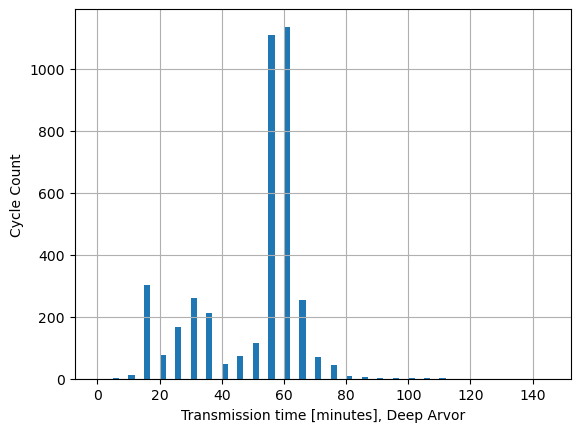

In [76]:
_=plt.hist(c,bins=np.arange(0,150,5),width=2)
plt.xlabel('Transmission time [minutes], Deep Arvor')
plt.ylabel('Cycle Count')

In [51]:
df1 = xr.open_dataset('DeepArvorGroundings_all_tids_v2.nc')
df1

<xarray.Dataset> Size: 531kB
Dimensions:          (N_GRD: 3908)
Dimensions without coordinates: N_GRD
Data variables: (12/17)
    LATITUDE         (N_GRD) float64 31kB ...
    LONGITUDE        (N_GRD) float64 31kB ...
    PROFILER_TYPE    (N_GRD) float64 31kB ...
    CYCLE_NUMBER     (N_GRD) float64 31kB ...
    WMO              (N_GRD) float64 31kB ...
    GROUNDING_DATE   (N_GRD) datetime64[ns] 31kB ...
    ...               ...
    LATITUDE_C0      (N_GRD) float64 31kB ...
    LATITUDE_C1      (N_GRD) float64 31kB ...
    LONGITUDE_C0     (N_GRD) float64 31kB ...
    LONGITUDE_C1     (N_GRD) float64 31kB ...
    LATITUDE_C2      (N_GRD) float64 31kB ...
    LONGITUDE_C2     (N_GRD) float64 31kB ...
Attributes:
    title:              Grounding data from Deep Arvor floats
    author:             Kevin Balem
    author_affilation:  IFREMER-LOPS
    author_contact:     kevin.balem@ifremer.fr
    date:               2024-01-15T08:35:25
    Processing 1:       Only grounding occuring during descent to profile are...
    Processing 2:       Corrected positions are calculated from the first GPS...

In [14]:
c=np.zeros(len(df1.N_GRD))
f=np.zeros(len(df1.N_GRD))
d=np.zeros(len(df1.N_GRD))
e=np.zeros(len(df1.N_GRD))
for i in range(len(df1.N_GRD)):
    wmo = int(df1['WMO'].sel(N_GRD=i).values)
    cycle = df1['CYCLE_NUMBER'].sel(N_GRD=i).values
    #gen path
    urlt=glob.glob(f"/home/ref-argo/gdac/dac/*/{wmo}/*_Rtraj.nc")
    #traj file
    dt = xr.open_dataset(str(urlt[0]))        
    dt0 = dt[['CYCLE_NUMBER','JULD','PRES','LATITUDE','LONGITUDE','MEASUREMENT_CODE']].where(dt['CYCLE_NUMBER']==cycle,drop=True)
    grounding = dt0.where(dt0['MEASUREMENT_CODE']==901,drop=True).groupby('CYCLE_NUMBER').last() 
    ascent_end = dt0.where(dt0['MEASUREMENT_CODE']==600,drop=True)
    tr_start = dt0.where(dt0['MEASUREMENT_CODE']==700,drop=True)
    tr_end = dt0.where(dt0['MEASUREMENT_CODE']==800,drop=True)
    first_fix = dt0.where(dt0['MEASUREMENT_CODE']==703,drop=True).groupby('CYCLE_NUMBER').first()      

    dt1 = dt[['CYCLE_NUMBER','JULD','PRES','LATITUDE','LONGITUDE','MEASUREMENT_CODE']].where(dt['CYCLE_NUMBER']==cycle+1,drop=True)
    if(len(dt1.N_MEASUREMENT)==0):    
        descent_start = dt0.where(dt0['MEASUREMENT_CODE']==800,drop=True)
    else:
        try:
            descent_start = dt1.where(dt1['MEASUREMENT_CODE']==100,drop=True).groupby('CYCLE_NUMBER').first()  
        except:
            descent_start = dt0.where(dt0['MEASUREMENT_CODE']==800,drop=True)
    if(np.isnat(descent_start['JULD'].values[0])):
        descent_start = dt0.where(dt0['MEASUREMENT_CODE']==704,drop=True)     

    c[i]=(descent_start['JULD'].values-ascent_end['JULD'].values).astype('timedelta64[m]').astype(int)
    f[i]=(tr_end['JULD'].values-tr_start['JULD'].values).astype('timedelta64[m]').astype(int)
    d[i]=(tr_start['JULD'].values-ascent_end['JULD'].values).astype('timedelta64[m]').astype(int)
    e[i]=(descent_start['JULD'].values-tr_end['JULD'].values).astype('timedelta64[m]').astype(int)

/tmp/ipykernel_10149/3306717502.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c[i]=(descent_start['JULD'].values-ascent_end['JULD'].values).astype('timedelta64[m]').astype(int)
/tmp/ipykernel_10149/3306717502.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f[i]=(tr_end['JULD'].values-tr_start['JULD'].values).astype('timedelta64[m]').astype(int)
/tmp/ipykernel_10149/3306717502.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d[i]=(tr_start['JULD'].va

Text(0, 0.5, 'Cycle Count')

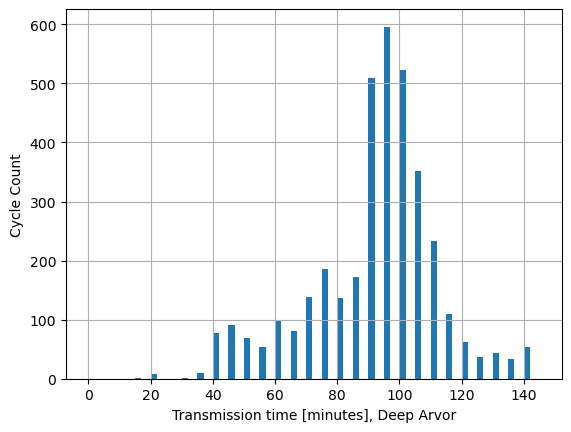

In [17]:
_=plt.hist(c,bins=np.arange(0,150,5),width=2)
plt.xlabel('Transmission time [minutes], Deep Arvor')
plt.ylabel('Cycle Count')

In [72]:
i=405
wmo = int(df1['WMO'].sel(N_GRD=i).values)
cycle = df1['CYCLE_NUMBER'].sel(N_GRD=i).values
print(wmo,cycle,c[i],d[i],f[i],e[i])

3902127 12.0 62.0 26.0 40.0 41.0


Text(0, 0.5, 'Cycle Count')

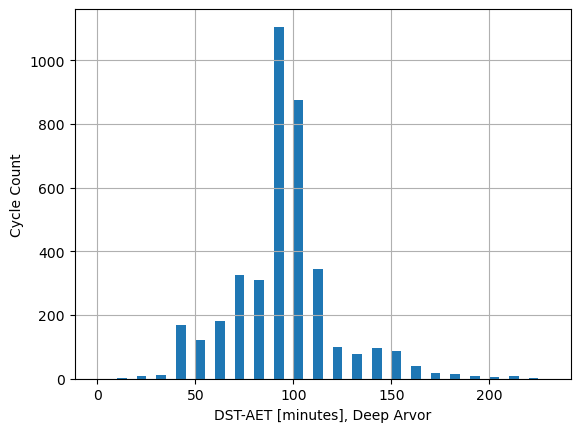

In [51]:
_=plt.hist(c,bins=np.arange(0,240,10),width=5)
plt.xlabel('DST-AET [minutes], Deep Arvor')
plt.ylabel('Cycle Count')

In [128]:
grnd=np.zeros(len(df1.N_GRD.values),dtype=np.float64)      # bathymetry estimate a.k.a grounding from the Deep Arvor floats
jae_grnd=np.zeros(len(df1.N_GRD.values),dtype=np.float64)  # julian day of ascent end time for surface interval after Deep Arvor grounding
jday_gps=np.zeros(len(df1.N_GRD.values),dtype=np.float64)  # julian day of first gps location after Deep Arvor grounding
jds_grnd=np.zeros(len(df1.N_GRD.values),dtype=np.float64)  # julian day of descent start time for surface interval after Deep Arvor grounding
jday_grnd=np.zeros(len(df1.N_GRD.values),dtype=np.float64) # julian day of Deep Arvor grounding
lat_gps=np.zeros(len(df1.N_GRD.values),dtype=np.float64)   # latitude of first gps location after Deep Arvor grounding*
lon_gps=np.zeros(len(df1.N_GRD.values),dtype=np.float64)   # longitude of first gps location after Deep Arvor grounding*
dir_grnd=np.zeros(len(df1.N_GRD.values),dtype=int)+2       #flag for profile direction : 2 for ascending_cy
wmol = np.zeros(len(df1.N_GRD.values),dtype=int)
cyc = np.zeros(len(df1.N_GRD.values),dtype=int)

In [129]:
for i in df1.N_GRD.values :   
    wmo = int(df1['WMO'].sel(N_GRD=i).values)
    cycle = df1['CYCLE_NUMBER'].sel(N_GRD=i).values
    #gen path
    urlt=glob.glob(f"/home/ref-argo/gdac/dac/*/{wmo}/*_Rtraj.nc")
    #traj file
    dt = xr.open_dataset(str(urlt[0]))        
    dt0 = dt[['CYCLE_NUMBER','JULD','PRES','LATITUDE','LONGITUDE','MEASUREMENT_CODE']].where(dt['CYCLE_NUMBER']==cycle,drop=True)
    grounding = dt0.where(dt0['MEASUREMENT_CODE']==901,drop=True).groupby('CYCLE_NUMBER').last() 
    ascent_end = dt0.where(dt0['MEASUREMENT_CODE']==590,drop=True).groupby('CYCLE_NUMBER').last()
    first_fix = dt0.where(dt0['MEASUREMENT_CODE']==703,drop=True).groupby('CYCLE_NUMBER').first()      
    descent_start = dt0.where(dt0['MEASUREMENT_CODE']==704,drop=True)        
    
    #assign
    ref=np.datetime64('1950-01-01T00:00:00')
    grnd[i]      = -1*gsw.z_from_p(grounding['PRES'].values,first_fix['LATITUDE'].values)[0]            
    jae_grnd[i]  = np.timedelta64(ascent_end['JULD'].values[0]-ref,'s').astype(float)/(3600*24) if ~np.isnat(ascent_end['JULD'].values[0]) else np.nan
    jday_gps[i]  = np.timedelta64(first_fix['JULD'].values[0]-ref,'s').astype(float)/(3600*24) if ~np.isnat(first_fix['JULD'].values[0]) else np.nan
    jds_grnd[i]  = np.timedelta64(descent_start['JULD'].values[0]-ref,'s').astype(float)/(3600*24) if ~np.isnat(descent_start['JULD'].values[0]) else np.nan
    jday_grnd[i] = np.timedelta64(grounding['JULD'].values[0]-ref,'s').astype(float)/(3600*24) if ~np.isnat(grounding['JULD'].values[0]) else np.nan
    lat_gps[i] = first_fix['LATITUDE'].values[0]
    lon_gps[i] = first_fix['LONGITUDE'].values[0]
    wmol[i]=int(wmo)
    cyc[i]=int(cycle)

In [130]:
#remove any weird points
ix=((jday_grnd<jae_grnd)&(jae_grnd<jday_gps)&(jday_gps<jds_grnd))
np.argwhere(~ix)

array([[3200],
       [3385]])

In [142]:
lat_gps2=np.delete(lat_gps,np.argwhere(~ix))
lon_gps2=np.delete(lon_gps,np.argwhere(~ix))
grnd2=np.delete(grnd,np.argwhere(~ix))
jday_grnd2=np.delete(jday_grnd,np.argwhere(~ix))
jae_grnd2=np.delete(jae_grnd,np.argwhere(~ix))
jday_gps2=np.delete(jday_gps,np.argwhere(~ix))
jds_grnd2=np.delete(jds_grnd,np.argwhere(~ix))
wmol2=np.delete(wmol,np.argwhere(~ix))
cyc2=np.delete(cyc,np.argwhere(~ix))

In [144]:
i=3200
print(jday_grnd[i],jae_grnd[i],jday_gps[i],jds_grnd[i])

26748.48611111111 26747.987013888887 26749.002951388888 26749.027962962962


In [146]:
ds_out = xr.Dataset({"lat_gps":(["N_GRD"],lat_gps2),
                     "lon_gps": (["N_GRD"],lon_gps2),
                     "grnd": (["N_GRD"],grnd2), 
                     "jday_grnd": (["N_GRD"],jday_grnd2),
                     "jae_grnd": (["N_GRD"],jae_grnd2),
                     "jday_gps": (["N_GRD"],jday_gps2),
                     "jds_grnd": (["N_GRD"],jds_grnd2),
                     "wmo": (["N_GRD"],wmol2),
                     "cycle": (["N_GRD"],cyc2) },coords={})
ds_out

<xarray.Dataset> Size: 281kB
Dimensions:    (N_GRD: 3906)
Dimensions without coordinates: N_GRD
Data variables:
    lat_gps    (N_GRD) float64 31kB 47.33 47.29 47.36 ... 50.77 35.61 72.16
    lon_gps    (N_GRD) float64 31kB -8.415 -8.444 -8.452 ... -16.16 -0.4657
    grnd       (N_GRD) float64 31kB 2.714e+03 3.399e+03 ... 3.223e+03 2.245e+03
    jday_grnd  (N_GRD) float64 31kB 2.358e+04 2.359e+04 ... 2.7e+04 2.7e+04
    jae_grnd   (N_GRD) float64 31kB 2.358e+04 2.359e+04 ... 2.7e+04 2.7e+04
    jday_gps   (N_GRD) float64 31kB 2.358e+04 2.359e+04 ... 2.7e+04 2.7e+04
    jds_grnd   (N_GRD) float64 31kB 2.358e+04 2.359e+04 ... 2.7e+04 2.7e+04
    wmo        (N_GRD) int64 31kB 6901597 6901597 6901597 ... 6903071 6903573
    cycle      (N_GRD) int64 31kB 81 83 85 86 87 88 41 ... 2 17 16 121 105 123

In [147]:
{k: dt['JULD'].attrs[k] for k in ('long_name', 'standard_name', 'conventions','axis')}

{'long_name': 'Julian day (UTC) of each measurement relative to REFERENCE_DATE_TIME',
 'standard_name': 'time',
 'conventions': 'Relative julian days with decimal part (as parts of day)',
 'axis': 'T'}

In [148]:
ds_out['lat_gps'].attrs=dt['LATITUDE'].attrs
ds_out['lat_gps'].attrs['long_name'] = 'Latitude of the first GPS fix following the grounding'
ds_out['lon_gps'].attrs=dt['LONGITUDE'].attrs
ds_out['lon_gps'].attrs['long_name'] = 'Latitude of the first GPS fix following the grounding'

ds_out['grnd'].attrs = {'long_name': 'Grounding depth','units': 'm'}

ds_out['jday_grnd'].attrs = {k: dt['JULD'].attrs[k] for k in ('standard_name', 'conventions','axis')}
ds_out['jday_grnd'].attrs['long_name']= 'Julian day of Deep Arvor grounding'
ds_out['jday_grnd'].attrs['units']= 'days since 1950-01-01 00:00:00 UTC'

ds_out['jae_grnd'].attrs = {k: dt['JULD'].attrs[k] for k in ('standard_name', 'conventions','axis')}
ds_out['jae_grnd'].attrs['long_name']= 'Julian day of ascent end time after grounding'
ds_out['jae_grnd'].attrs['units']= 'days since 1950-01-01 00:00:00 UTC'

ds_out['jday_gps'].attrs = {k: dt['JULD'].attrs[k] for k in ('standard_name', 'conventions','axis')}
ds_out['jday_gps'].attrs['long_name']= 'Julian day of first gps location after grounding'
ds_out['jday_gps'].attrs['units']= 'days since 1950-01-01 00:00:00 UTC'

ds_out['jds_grnd'].attrs = {k: dt['JULD'].attrs[k] for k in ('standard_name', 'conventions','axis')}
ds_out['jds_grnd'].attrs['long_name'] = 'Julian day of descent start time after Deep Arvor grounding'
ds_out['jds_grnd'].attrs['units']= 'days since 1950-01-01 00:00:00 UTC'

ds_out['wmo'].attrs = {'long_name': 'Wmo instrument code'}
ds_out['cycle'].attrs = {'long_name': 'Cycle number'}

In [149]:
ds_out.load()

<xarray.Dataset> Size: 281kB
Dimensions:    (N_GRD: 3906)
Dimensions without coordinates: N_GRD
Data variables:
    lat_gps    (N_GRD) float64 31kB 47.33 47.29 47.36 ... 50.77 35.61 72.16
    lon_gps    (N_GRD) float64 31kB -8.415 -8.444 -8.452 ... -16.16 -0.4657
    grnd       (N_GRD) float64 31kB 2.714e+03 3.399e+03 ... 3.223e+03 2.245e+03
    jday_grnd  (N_GRD) float64 31kB 2.358e+04 2.359e+04 ... 2.7e+04 2.7e+04
    jae_grnd   (N_GRD) float64 31kB 2.358e+04 2.359e+04 ... 2.7e+04 2.7e+04
    jday_gps   (N_GRD) float64 31kB 2.358e+04 2.359e+04 ... 2.7e+04 2.7e+04
    jds_grnd   (N_GRD) float64 31kB 2.358e+04 2.359e+04 ... 2.7e+04 2.7e+04
    wmo        (N_GRD) int64 31kB 6901597 6901597 6901597 ... 6903071 6903573
    cycle      (N_GRD) int64 31kB 81 83 85 86 87 88 41 ... 2 17 16 121 105 123

In [150]:
ds_out.to_netcdf('DeepArvorGrounding_ABYSS_June24.nc')

In [159]:
ds_rec = xr.open_dataset('DeepArvorGrounding_ABYSS_June24.nc')

In [163]:
ix=((ds_rec['jday_grnd']<ds_rec['jae_grnd'])&(ds_rec['jae_grnd']<ds_rec['jday_gps'])&(ds_rec['jday_gps']<ds_rec['jds_grnd']))
np.argwhere(~ix.values)

array([], shape=(0, 1), dtype=int64)

In [165]:
(ds_rec['jds_grnd']-ds_rec['jae_grnd'])/(1e9*60)

<xarray.DataArray (N_GRD: 3906)> Size: 31kB
array([18, 19, 18, ..., 63, 59, 36], dtype='timedelta64[ns]')
Dimensions without coordinates: N_GRD

Text(0, 0.5, 'Cycle Count')

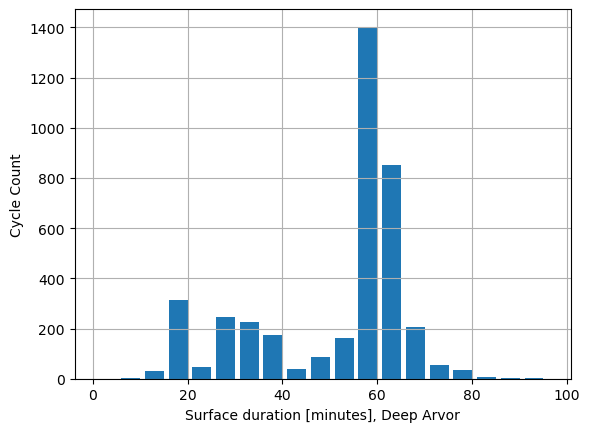

In [215]:
c=((ds_rec['jds_grnd']-ds_rec['jae_grnd'])/(1e9*60)).astype(float)
_=c.plot.hist(bins=np.arange(1,100,5),width=4)
plt.xlabel('Surface duration [minutes], Deep Arvor')
plt.ylabel('Cycle Count')

In [192]:
np.argwhere(c.values>120)

array([[ 404],
       [3081],
       [3153],
       [3360],
       [3390],
       [3746]])

In [213]:
ds_rec[['wmo','cycle']].isel(N_GRD=3746).load()

<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    wmo      int64 8B 6902974
    cycle    int64 8B 119

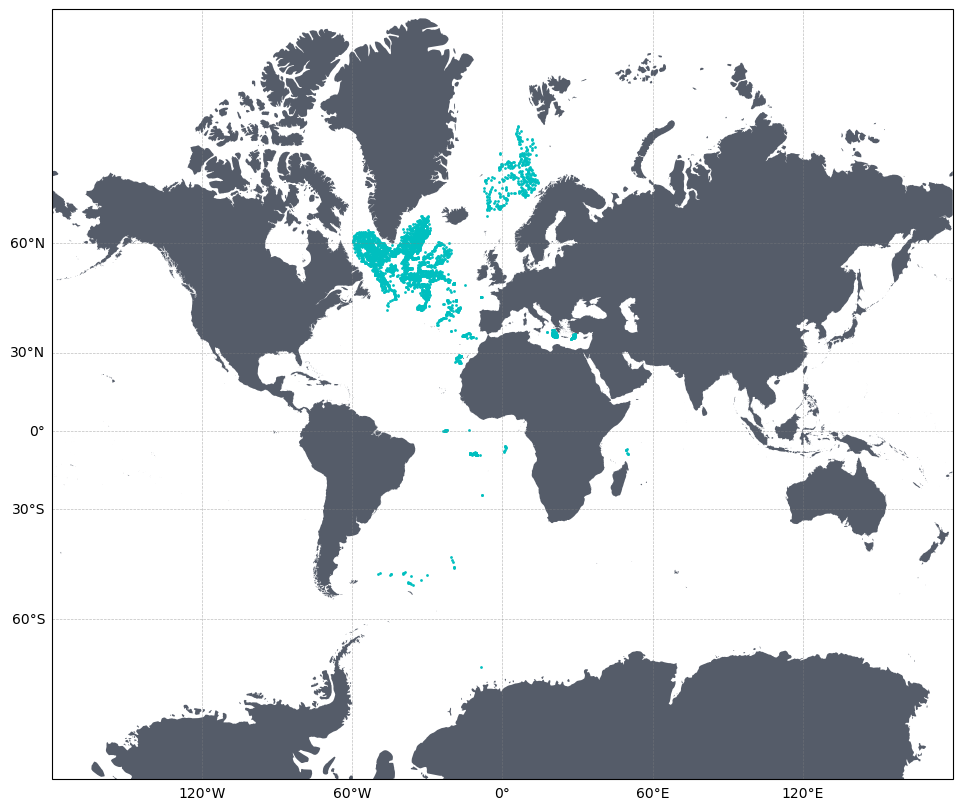

In [212]:
fig=plt.figure(figsize=(12,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.add_feature(land_feature, edgecolor=None)

#ds_reci=ds_rec.isel(N_GRD=3390).load()
ax.plot(ds_rec['lon_gps'],ds_rec['lat_gps'],'.c', markersize=4, markeredgecolor='None', alpha=1, transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.set_global()